In [110]:
import json

import pandas as pd
import numpy as np

import string

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from numpy import array

from numpy import asarray
from numpy import zeros

----

In [29]:
with open('/Users/ella.franks/PycharmProjects/twitter_experts/experts.json') as file:
    experts = pd.DataFrame(json.load(file))
    experts['expert'] = 1
with open('/Users/ella.franks/PycharmProjects/twitter_experts/non_experts.json') as file:
    non_experts_1 = pd.DataFrame(json.load(file))
    non_experts_1['expert'] = 0 
with open('/Users/ella.franks/PycharmProjects/twitter_experts/non_experts_second_round.json') as file:
    non_experts_2 = pd.DataFrame(json.load(file)) 
    non_experts_2['expert'] = 0 
with open('/Users/ella.franks/PycharmProjects/twitter_experts/non_experts_third_round.json') as file:
    non_experts_3 = pd.DataFrame(json.load(file)) 
    non_experts_3['expert'] = 0
    

In [30]:
pdList = [experts, non_experts_1, non_experts_2, non_experts_3]

df = pd.concat(pdList).drop_duplicates(subset=['tweet_id']).reset_index(drop=True)

df *= 1

In [31]:
df.shape

(27142, 24)

---

In [33]:
df['expert'].value_counts(normalize=True)

0    0.666716
1    0.333284
Name: expert, dtype: float64

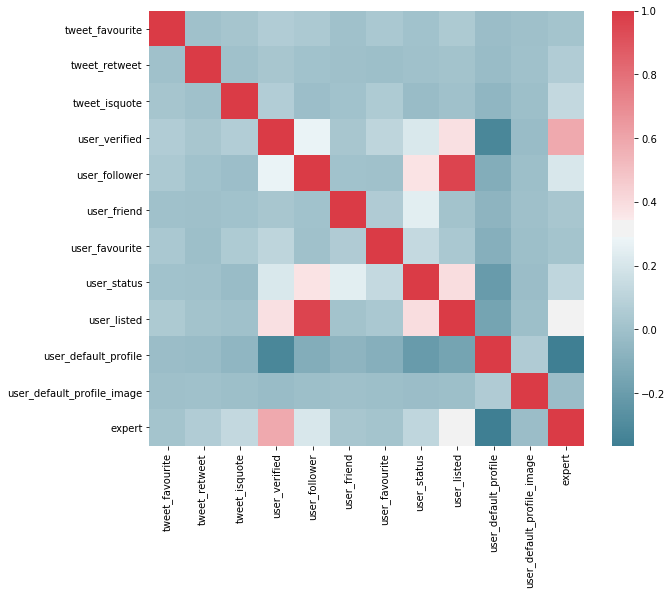

In [34]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), mask=np.zeros_like(df.corr(), dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

***Looks like being verified and having the default profile image correlates with being a twitter tech expert. Interesting that followers, retweets, favourties do not seem to be contributing. Is this because of the data collected?***

--- 

# Improve quality of the data: 
**Filter any experts in non-experts and classify them as experts**

Disregard any experts with less than 1000 followers and move any 'official' experts found in the non-experts tweets

In [78]:
df = df[~((df['expert']==1) & (df['user_follower']<1000))]

In [79]:
experts_list = df[df['expert'] == 1].user_name.unique()

In [80]:
df = df[~((df['expert']==0) & (df['user_name'].isin(experts_list)))]

In [81]:
non_experts = df[df['expert'] == 0]

Create an ideal balanced subset of 1 tweet per expert and non expert 

In [96]:
experts = df[df['expert'] == 1].sample(frac=1).drop_duplicates(subset='user_name', keep='first')

In [146]:
non_experts = non_experts[(non_experts['user_follower']>90) & \
                          (non_experts['user_follower']<105) & \
                          (non_experts['user_friend']>0)].sample(frac=1).drop_duplicates(subset='user_name', keep='first')

In [147]:
mini_df = pd.concat([experts, non_experts]).sample(frac=1).reset_index(drop=True)

In [148]:
mini_df['expert'].value_counts(normalize=True)

0    0.560386
1    0.439614
Name: expert, dtype: float64

### Using description to predict

In [149]:
y = mini_df.pop('expert')
X = mini_df['user_description']

In [150]:
vectorizer = TfidfVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(X)

In [151]:
clf = RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=1)
clf.fit(X_vec, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [152]:
cross_val_score(clf, X_vec, y, cv=3)

array([0.69565217, 0.66666667, 0.65217391])

In [153]:
results = pd.DataFrame({'prediction':clf.predict(X_vec), 'proba':clf.predict_proba(X_vec).max(axis=1), 'true_label':y})

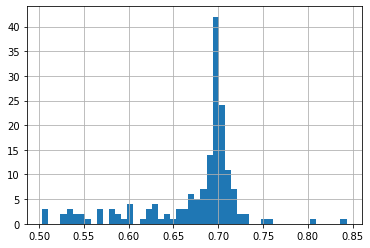

In [154]:
results[results['prediction']==results['true_label']].proba.hist(bins=50);

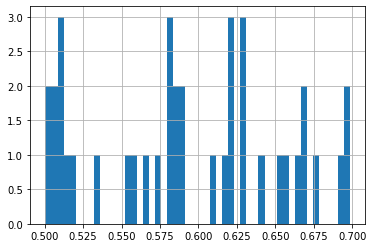

In [155]:
results[results['prediction']!=results['true_label']].proba.hist(bins=50);

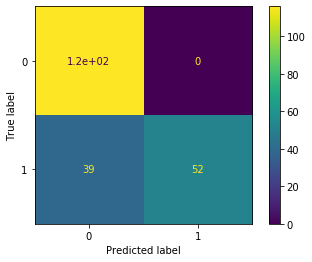

In [156]:
plot_confusion_matrix(clf, X_vec, y);

In [201]:
pd.DataFrame({'imps': clf.feature_importances_, \
              'label': vectorizer.get_feature_names()}).sort_values(by='imps').tail(10)

,imps,label
1180,0.013255,tech
531,0.014222,geek
918,0.016496,podcaster
222,0.022398,chief
599,0.025414,host
81,0.026483,analyst
111,0.030526,author
603,0.031699,https
398,0.050778,editor
511,0.062707,founder


In [158]:
preds = pd.DataFrame(clf.predict_proba(vectorizer.transform(df['user_description'])), columns=['non','exp'])

In [159]:
preds[preds['non']>0.5]

,non,exp
0,0.627704,0.372296
1,0.627704,0.372296
2,0.627704,0.372296
3,0.627704,0.372296
4,0.627704,0.372296
...,...,...
27029,0.684964,0.315036
27031,0.524596,0.475404
27032,0.678042,0.321958
27033,0.645143,0.354857


### Using tweets to predict

In [160]:
X_tweet = mini_df['full_text']

X_tweet.apply(lambda x: x.lower())

vectorizer_combined = TfidfVectorizer(stop_words='english')
X_vec_tweet = vectorizer_combined.fit_transform(X_tweet)

clf_tweet = RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=1)
clf_tweet.fit(X_vec_tweet, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [161]:
cross_val_score(clf_tweet, X_vec_tweet, y, cv=3)

array([0.66666667, 0.65217391, 0.71014493])

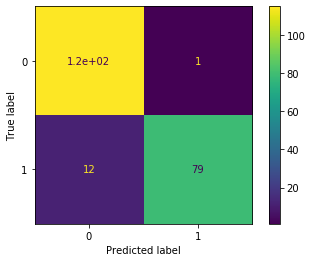

In [162]:
plot_confusion_matrix(clf_tweet, X_vec_tweet, y);

### Using description and tweets to predict

In [163]:
X_combined = mini_df['user_description'] + mini_df['full_text']

X_combined.apply(lambda x: x.lower())

vectorizer_combined = TfidfVectorizer(stop_words='english')
X_vec_combined = vectorizer_combined.fit_transform(X_combined)

clf_combined = RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=1)
clf_combined.fit(X_vec_combined, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [164]:
cross_val_score(clf_combined, X_vec_combined, y, cv=3)

array([0.66666667, 0.7826087 , 0.71014493])

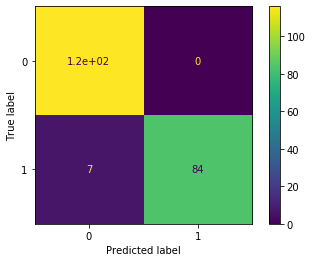

In [165]:
plot_confusion_matrix(clf_combined, X_vec_combined, y);

In [182]:
results = pd.DataFrame({'prediction':clf_combined.predict(X_vec_combined), 
                        'proba':clf_combined.predict_proba(X_vec_combined).max(axis=1), 'true_label':y,
                        'comb_text': mini_df['user_description'] + mini_df['full_text'],
                        'user_screename': mini_df['user_screename']})

In [204]:
pd.DataFrame({'imps': clf_combined.feature_importances_, \
              'label': vectorizer_combined.get_feature_names()}).sort_values(by='imps').tail(10)

,imps,label
509,0.011695,chief
2702,0.011731,technology
483,0.012872,ceo
196,0.013868,analyst
1140,0.018722,founder
255,0.020099,author
1357,0.022528,https
2344,0.027085,rt
902,0.029040,editor
2691,0.127407,tech


In [183]:
results[results['prediction']!=results['true_label']]

,prediction,proba,true_label,comb_text,user_screename
19,0,0.522553,1,"Tech contributor to @bospublicradio @WGBH, pod...",Ihnatko
54,0,0.507380,1,Tech journalist. Author of 20+ books.\nWoody G...,edbott
111,0,0.519148,1,"4. They never sell your data, to anyone, ever....",kevinrose
117,0,0.554677,1,Content and Communications strategist. Longtim...,sammyd
134,0,0.501035,1,"Co-founder @TheRecount, a founder of NewCo, so...",johnbattelle
164,0,0.580812,1,"Host of Marketplace Tech on radio, also 300 ep...",mollywood
200,0,0.590332,1,Tech journo who covered IT for the Guardian (1...,jackschofield


In [196]:
preds_combined = pd.DataFrame(clf_combined.predict_proba(
                    vectorizer_combined.transform(df['user_description']+df['full_text'])), columns=['non','exp'])

In [200]:
preds_combined[preds_combined['non']>0.5].shape[0]/df.shape[0]

0.6520436471240983

In [187]:
df['expert'].value_counts(normalize=True)

0    0.666802
1    0.333198
Name: expert, dtype: float64

***Looks like the combined model using both the tweets and the description is generalising very well to the bigger dataset***

---

In [205]:
df.to_csv("attempt_1.csv")